In [4]:
import numpy as np
import pandas as pd
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql import functions as f

spark = SparkSession.builder.enableHiveSupport().getOrCreate()

# Suppresses user warinig messages in Python
import warnings
warnings.simplefilter("ignore", UserWarning)

# Suppresses `WARN` messages in JVM
spark.sparkContext.setLogLevel("ERROR")

NOTE: SPARK_PREPEND_CLASSES is set, placing locally compiled Spark classes ahead of assembly.
21/11/19 21:21:34 WARN Utils: Your hostname, maropus-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.3.4 instead (on interface en0)
21/11/19 21:21:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/19 21:21:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
import importlib
ptesting_model = importlib.import_module("ptesting-model")
features = importlib.import_module("features")

In [6]:
import json
from pathlib import Path 
from ptesting import github_utils

test_files = json.loads(Path('../models/spark/indexes/latest/test-files.json').read_text())
commits = json.loads(Path('../models/spark/logs/commits.json').read_text())
repo_commits = list(map(lambda c: github_utils.from_github_datetime(c[0]), commits))
updated_file_stats = json.loads(Path('../models/spark/logs/updated-file-stats.json').read_text())
failed_tests = json.loads(Path('../models/spark/failed-tests.json').read_text())
contributor_stats = json.loads(Path('../models/spark/logs/contributor-stats.json').read_text())
dep_graph = json.loads(Path('../models/spark/indexes/latest/dep-graph.json').read_text())
corr_files = json.loads(Path('../models/spark/indexes/latest/correlated-files.json').read_text())

# Removes comment entries from `excluded_tests`/`included_tests`
excluded_tests = json.loads(Path('../models/spark/logs/excluded-tests.json').read_text())
excluded_tests = list(filter(lambda t: not t.startswith('$comment'), excluded_tests))

included_tests = json.loads(Path('../models/spark/logs/included-tests.json').read_text())
included_tests = list(filter(lambda t: not t.startswith('$comment'), included_tests))

# Removes the excluded tests from `test_files`
test_files = {k: test_files[k] for k in test_files if k not in excluded_tests}

In [7]:
expected_input_cols = [                                                                                                                                                                                                                       
    'author',
    'case when length(sha) > 0 then sha else sha(string(random())) end sha',
    'commit_date',
    'array_distinct(failed_tests) failed_tests',
    'files' 
]

log_data_df = spark.read.format('json').load('../models/spark/logs/github-logs.json').selectExpr(expected_input_cols)
log_data_df = ptesting_model._exclude_tests_from(log_data_df, excluded_tests)
log_data_df.orderBy(f.expr('commit_date').desc()).show(3)

+-------------+--------------------+-------------------+------------+--------------------+
|       author|                 sha|        commit_date|failed_tests|               files|
+-------------+--------------------+-------------------+------------+--------------------+
|        dchvn|3f529f9bdf3349679...|2021/11/10 10:07:25|          []|[{{1, 1, 0, pytho...|
|     beliefer|dc46ba4ffa445bf92...|2021/11/10 09:00:30|          []|[{{7, 9, 2, sql/c...|
|linhongliu-db|48ffd8145621c6d5f...|2021/11/10 05:32:28|          []|[{{42, 42, 0, sql...|
+-------------+--------------------+-------------------+------------+--------------------+
only showing top 3 rows



In [3]:
def _train_test_split(df, test_ratio):
    test_df = df.sample(test_ratio)
    train_df = df.subtract(test_df)
    return train_df, test_df

In [8]:
train_df, test_df = ptesting_model._train_test_split(log_data_df, test_ratio=0.15)
# train_df, test_df = _train_test_split(log_data_df, test_ratio=0.20)

In [10]:
corr_files_from_failed_tests = features.extract_correlated_files_from_failed_tests(train_df)
for key, value in corr_files_from_failed_tests.items():
    corr_files[key] = list(set(corr_files[key] + value)) if key in corr_files else value

In [11]:
to_train_features, to_test_features = features.create_train_test_pipeline(spark, test_files, repo_commits, dep_graph, corr_files, included_tests, updated_file_stats, contributor_stats, failed_tests)

In [25]:
pdf = to_train_features(train_df).cache().toPandas()

2021-11-19 21:28:18.921 INFO features: to_train_features: enrich_authors(author) -> [num_commits] added, [] removed
2021-11-19 21:28:19.025 INFO features: to_train_features: enrich_files(commit_date,files.file.name) -> [updated_num_14d,updated_num_56d,updated_num_3d,updated_num_56c,updated_num_14c,updated_num_3c,updated_file_stats,ufs] added, [] removed
2021-11-19 21:28:19.055 INFO features: to_train_features: expand_updated_stats(files) -> [num_dels,num_adds,num_chgs] added, [] removed
2021-11-19 21:28:19.156 INFO features: to_train_features: enumerate_related_tests(sha,files) -> [related_tests,target_card] added, [] removed
2021-11-19 21:28:19.228 INFO features: to_train_features: add_failed_column(related_tests,failed_tests) -> [tests,test,failed] added, [] removed
2021-11-19 21:28:19.344 INFO features: to_train_features: enrich_tests(commit_date,test) -> [failed_num_28c,failed_num_14c,failed_num_14d,failed_num_7c,fts,failed_num_28d,failed_test_stats,total_failed_num,failed_num_7d] 

In [10]:
pdf.dtypes

failed                                  int32
num_commits                             int32
updated_num_3d                          int32
updated_num_14d                         int32
updated_num_56d                         int32
updated_num_3c                          int32
updated_num_14c                         int32
updated_num_56c                         int32
num_adds                                int32
num_dels                                int32
num_chgs                                int32
file_card                               int32
failed_num_7d                           int32
failed_num_14d                          int32
failed_num_28d                          int32
failed_num_7c                           int32
failed_num_14c                          int32
failed_num_28c                          int32
total_failed_num                        int32
path_difference                         int32
distance                                int32
total_failed_num__x__num_commits  

In [13]:
from ptesting import train

X = pdf[pdf.columns[pdf.columns != 'failed']]
y = pdf['failed']
X, y = train.rebalance_training_data(X, y, coeff=2.0)
pdf = X.copy(deep=True)
pdf['failed'] = y

2021-11-19 21:25:34.796 INFO train: Sampling training data (strategy={0: 1672, 1: 836}): {0: 215931, 1: 836} => {0: 1672, 1: 836}


In [12]:
X.describe()

,num_commits,updated_num_3d,updated_num_14d,updated_num_56d,updated_num_3c,updated_num_14c,updated_num_56c,num_adds,num_dels,num_chgs,...,failed_num_7d__x__num_chgs,failed_num_7d__x__updated_num_56d,failed_num_7d__x__updated_num_56c,failed_num_7d__x__path_difference,failed_num_7d__x__distance,distance__x__num_commits,distance__x__num_chgs,distance__x__updated_num_56d,distance__x__updated_num_56c,distance__x__path_difference
count,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,...,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,7.440000e+02,744.000000,744.000000,744.000000
mean,107.169355,0.698925,3.297043,12.681452,0.298387,0.537634,1.446237,947.900538,175.260753,1123.161290,...,233.533602,6.104839,0.629032,0.622312,13.944892,5066.123656,2.671816e+04,456.115591,42.908602,136.287634
std,179.377541,1.761163,4.693765,15.464956,1.487389,1.612930,2.172832,8327.691576,597.924874,8459.789144,...,1058.681323,17.011350,1.642968,1.548181,48.849795,14547.353545,1.127355e+05,1447.332459,145.749771,252.980283
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,58.000000,7.000000,73.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.915000e+02,0.000000,0.000000,2.000000
50%,0.000000,0.000000,2.000000,8.000000,0.000000,0.000000,1.000000,120.000000,24.000000,161.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.980000e+02,19.000000,0.000000,6.000000
75%,190.000000,1.000000,5.000000,18.000000,0.000000,1.000000,2.000000,255.000000,77.000000,329.750000,...,52.000000,1.000000,0.000000,0.000000,1.000000,393.000000,4.206000e+03,84.000000,6.000000,128.000000
max,887.000000,21.000000,29.000000,100.000000,20.000000,21.000000,21.000000,130829.000000,5125.000000,132030.000000,...,10361.000000,200.000000,12.000000,12.000000,384.000000,113536.000000,1.007104e+06,12800.000000,1152.000000,1152.000000


In [14]:
def to_histogram_seaborn_numeirc_only(X):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    fig = plt.figure(figsize=(20, 16))
    return X.hist(ax=fig.gca())

array([[<AxesSubplot:title={'center':'num_commits'}>,
        <AxesSubplot:title={'center':'updated_num_3d'}>,
        <AxesSubplot:title={'center':'updated_num_14d'}>,
        <AxesSubplot:title={'center':'updated_num_56d'}>,
        <AxesSubplot:title={'center':'updated_num_3c'}>,
        <AxesSubplot:title={'center':'updated_num_14c'}>],
       [<AxesSubplot:title={'center':'updated_num_56c'}>,
        <AxesSubplot:title={'center':'num_adds'}>,
        <AxesSubplot:title={'center':'num_dels'}>,
        <AxesSubplot:title={'center':'num_chgs'}>,
        <AxesSubplot:title={'center':'file_card'}>,
        <AxesSubplot:title={'center':'failed_num_7d'}>],
       [<AxesSubplot:title={'center':'failed_num_14d'}>,
        <AxesSubplot:title={'center':'failed_num_28d'}>,
        <AxesSubplot:title={'center':'failed_num_7c'}>,
        <AxesSubplot:title={'center':'failed_num_14c'}>,
        <AxesSubplot:title={'center':'failed_num_28c'}>,
        <AxesSubplot:title={'center':'total_failed_nu

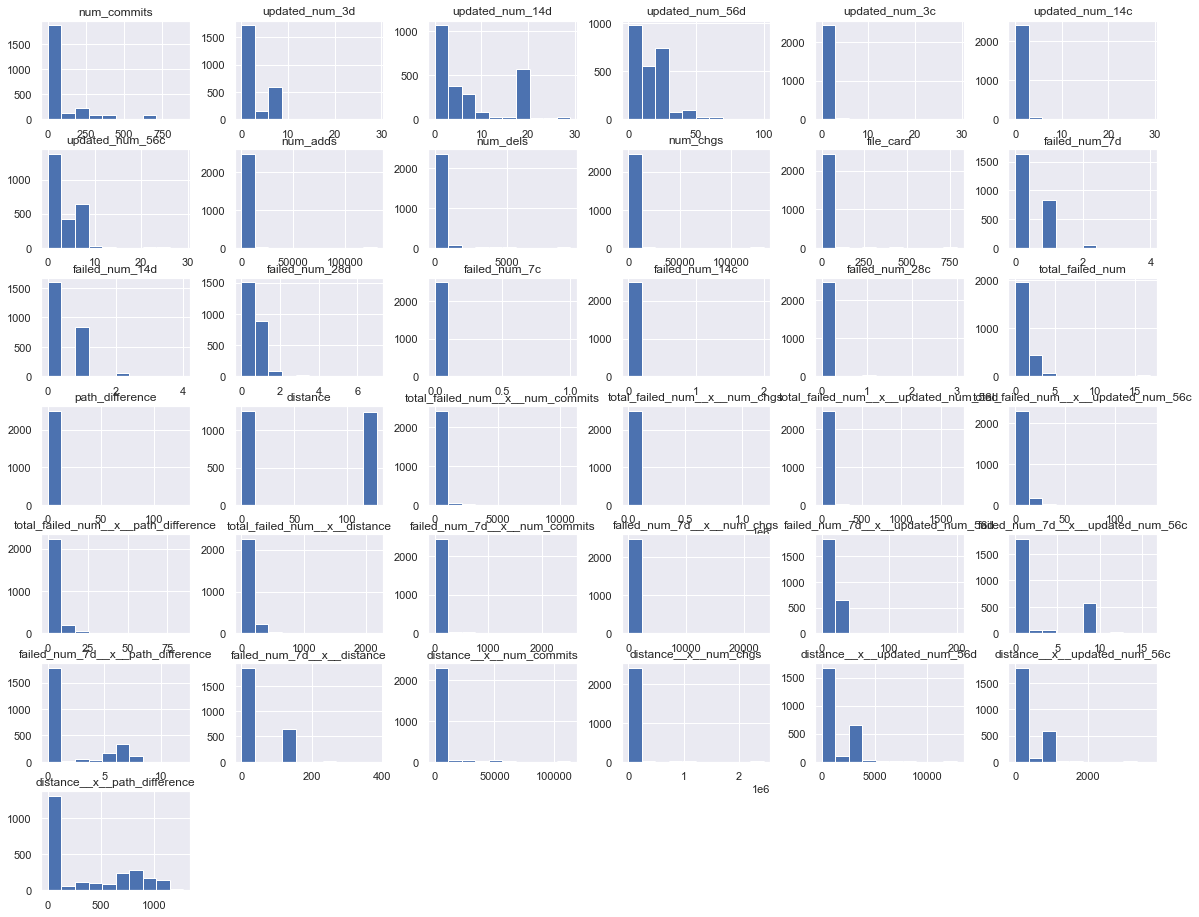

In [15]:
to_histogram_seaborn_numeirc_only(X)

In [15]:
def to_splom_altair(X, target):
    import altair as alt
    chart = alt.Chart(X).mark_circle().encode(
        alt.X(alt.repeat("column"), type='quantitative'),
        alt.Y(alt.repeat("row"), type='quantitative'),
        color=f'{target}:N'
    )
    chart = chart.properties(width=100, height=100)
    chart = chart.repeat(
        row=X.columns.tolist(),
        column=X.columns.tolist()
    )
    return chart

In [16]:
to_splom_altair(pdf, target='failed')

alt.RepeatChart(...)

In [17]:
def to_corr_heatmap(X):    
    import matplotlib.pyplot as plt
    import seaborn as sns
    fig = plt.figure(figsize=(10, 8))
    return sns.heatmap(X.corr(method='pearson'), vmax=1, vmin=-1, center=0, ax=fig.gca())

<AxesSubplot:>

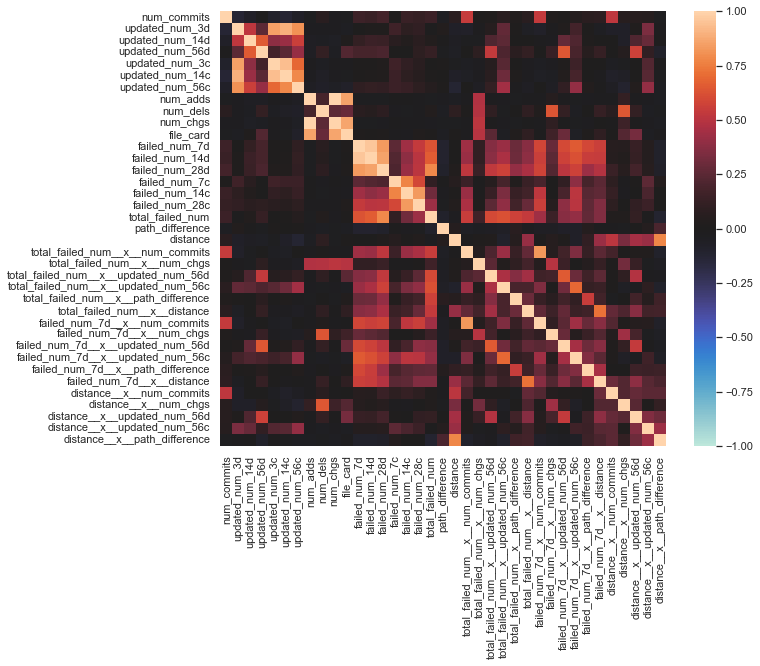

In [18]:
to_corr_heatmap(X)

In [19]:
def to_umap(X, y, target, n_neighbors=5, min_dist=0.3, metric='euclidean'):
    from umap import UMAP
    umap = UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    _data = umap.fit_transform(X)
    _X = pd.DataFrame({'tSNE-X': _data[:, 0], 'tSNE-Y': _data[:, 1], target: y})

    import altair as alt
    chart = alt.Chart(_X).mark_point().encode(x='tSNE-X', y='tSNE-Y', color=f'{target}:N').properties(width=600, height=400).interactive()
    return chart

In [20]:
to_umap(X, y, target='failed', n_neighbors=300, min_dist=1.0, metric='euclidean')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


alt.Chart(...)

In [16]:
from ptesting import train
params = {'hp.timeout': '3600', 'hp.no_progress_loss': '1'}
clf, score = train.build_model(X, y, opts=params)
print(f'Score: {score}')

Score: 0.9866642433258103


In [22]:
list(sorted(filter(lambda x: x[1] > 0.0, zip(clf.feature_name_, clf.feature_importances_)), key=lambda x: x[1], reverse=True))

[('failed_num_14d', 9086.234985351562),
 ('failed_num_7d__x__num_chgs', 6647.450872898102),
 ('failed_num_7d', 4968.269863128662),
 ('total_failed_num__x__num_chgs', 2216.0761944041587),
 ('failed_num_7d__x__distance', 2200.1530820429325),
 ('total_failed_num', 1576.07245139312),
 ('failed_num_7d__x__updated_num_56c', 1425.8530191071332),
 ('distance__x__num_chgs', 1355.4031597696012),
 ('num_commits', 1293.1810757464264),
 ('distance__x__path_difference', 903.8694657739252),
 ('total_failed_num__x__distance', 856.338231309317),
 ('failed_num_7d__x__updated_num_56d', 801.0389733463526),
 ('total_failed_num__x__num_commits', 792.0668539437465),
 ('distance', 708.1606531757861),
 ('total_failed_num__x__path_difference', 599.0991699807346),
 ('num_dels', 543.0898338822881),
 ('distance__x__num_commits', 521.7438447996974),
 ('failed_num_28d', 503.00060971826315),
 ('updated_num_56c', 477.08609972149134),
 ('total_failed_num__x__updated_num_56d', 435.7887285258621),
 ('total_failed_num__x_

In [17]:
df = ptesting_model._predict_failed_probs_for_tests(test_df, clf, to_test_features)
df = df.join(test_df, 'sha', 'INNER').selectExpr('sha', 'size(failed_tests) > 0 failed', 'failed_tests', 'inline(tests)')
df = df.selectExpr('sha', 'test', 'failed_prob', 'failed', 'failed_prob >= 0.50 predicted', 'failed_tests')

2021-11-19 21:25:43.745 INFO features: to_test_features: enrich_authors(author) -> [num_commits] added, [] removed
2021-11-19 21:25:43.841 INFO features: to_test_features: enrich_files(commit_date,files.file.name) -> [updated_num_14d,updated_num_56d,updated_num_3d,updated_num_56c,updated_num_14c,updated_num_3c,updated_file_stats,ufs] added, [] removed
2021-11-19 21:25:43.876 INFO features: to_test_features: expand_updated_stats(files) -> [num_dels,num_adds,num_chgs] added, [] removed
2021-11-19 21:25:44.019 INFO features: to_test_features: enumerate_related_tests(sha,files) -> [related_tests,target_card] added, [] removed
2021-11-19 21:25:44.032 INFO features: to_test_features: <lambda>(related_tests) -> [test] added, [] removed
2021-11-19 21:25:44.141 INFO features: to_test_features: enrich_tests(commit_date,test) -> [failed_num_28c,failed_num_14c,failed_num_14d,failed_num_7c,fts,failed_num_28d,failed_test_stats,total_failed_num,failed_num_7d] added, [] removed
2021-11-19 21:25:44.177

<AxesSubplot:>

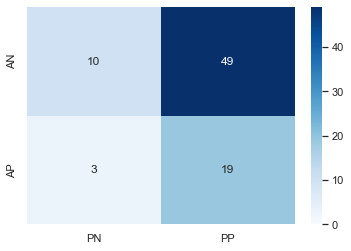

In [18]:
from pyspark.sql import functions as f
prob_thres = 0.50
predicted_pdf = df.groupBy('sha').agg(f.expr('first(failed) failed'), f.expr('array_max(collect_set(failed_prob)) failed_prob')).selectExpr('failed', f'failed_prob >= {prob_thres} predicted', 'failed_prob').toPandas()

import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predicted_pdf['failed'], predicted_pdf['predicted'])
sns.heatmap(pd.DataFrame(cm, index=['AN', 'AP'], columns=['PN', 'PP']), annot=True, cmap='Blues', vmin=0)

In [19]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(predicted_pdf['failed'], predicted_pdf['predicted'], target_names=['passed', 'failed'], output_dict=True))

,passed,failed,accuracy,macro avg,weighted avg
precision,0.769231,0.279412,0.358025,0.524321,0.636194
recall,0.169492,0.863636,0.358025,0.516564,0.358025
f1-score,0.277778,0.422222,0.358025,0.350000,0.317010
support,59.000000,22.000000,0.358025,81.000000,81.000000


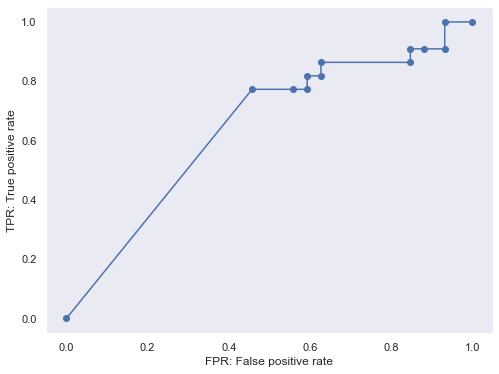

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

fpr, tpr, thres = roc_curve(predicted_pdf['failed'], predicted_pdf['failed_prob'])

sns.set()
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [21]:
rank_df = df.groupBy('sha').agg(f.expr('first(failed_tests) failed_tests'), f.expr('collect_set(named_struct("t", test, "p", failed_prob)) tests'))
rank_df = rank_df.selectExpr('sha', 'explode(failed_tests) failed_test', 'array_sort(tests, (l, r) -> case when l.p < r.p then 1 when l.p > r.p then -1 else 0 end) tests')
rank_df = rank_df.selectExpr('sha', 'failed_test', 'tests.t tests').selectExpr('sha', 'failed_test', 'array_position(tests, failed_test) rank')
rank_df = rank_df.selectExpr('sha', 'failed_test', 'case when rank = 0 then 1800 else rank end rank')
rank_pdf = rank_df.toPandas()
rank_pdf

,sha,failed_test,rank
0,2e50a6016499d23beff27c25122673de677c9025,org.apache.spark.sql.execution.DataSourceV2Sca...,67
1,f272a89a9a40e8bd2b514cb6c4c6f9bec9b5a38a,org.apache.spark.sql.hive.execution.HiveDDLSuite,27
2,f272a89a9a40e8bd2b514cb6c4c6f9bec9b5a38a,org.apache.spark.sql.hive.execution.HiveCompat...,21
3,f272a89a9a40e8bd2b514cb6c4c6f9bec9b5a38a,org.apache.spark.sql.hive.StatisticsSuite,33
4,f272a89a9a40e8bd2b514cb6c4c6f9bec9b5a38a,org.apache.spark.sql.hive.execution.command.Sh...,369
...,...,...,...
181,89fc1c0ac2d529972193e9feed1f35e8a93da00a,org.apache.spark.sql.hive.thriftserver.ThriftS...,12
182,89fc1c0ac2d529972193e9feed1f35e8a93da00a,org.apache.spark.sql.SQLQueryTestSuite,2
183,de0d183b72cf022cac2da1e860d2bd3f64e06d82,org.apache.spark.sql.SQLQueryTestSuite,3
184,de0d183b72cf022cac2da1e860d2bd3f64e06d82,org.apache.spark.sql.SubquerySuite,4


Text(0, 0.5, 'Cumulative ratio')

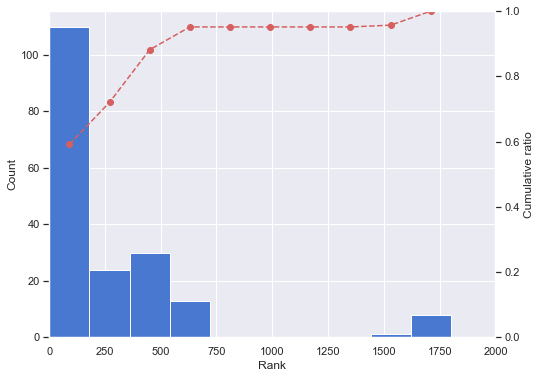

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid", palette="muted", color_codes=True)

fig, ax1 = plt.subplots(figsize=(8, 6))
n, bins, patches = ax1.hist(rank_pdf['rank'])
ax1.set_xlim([0, 2000])
ax1.set_xlabel("Rank")
ax1.set_ylabel("Count")

ax2 = ax1.twinx()
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o')
ax2.set_xlim([0, 2000])
ax2.set_ylim([0.0, 1.0])
ax2.grid(visible=False)
ax2.set_ylabel('Cumulative ratio')

In [23]:
coverage = []
num_rank_df = rank_df.count()
for t in [100, 200, 300, 400]:
    coverage.append(rank_df.where(f'rank < {t}').count() / num_rank_df)
    
print(coverage)

[0.5, 0.6021505376344086, 0.6612903225806451, 0.7473118279569892]


In [24]:
import json
result_df = rank_df.join(test_df, 'sha', 'INNER').selectExpr('sha', 'rank', 'failed_test', 'files.file.name filenames').orderBy(f.expr('rank').desc()).toPandas()
print(json.dumps(result_df.to_dict(orient='records'), indent=2))

[
  {
    "sha": "f272a89a9a40e8bd2b514cb6c4c6f9bec9b5a38a",
    "rank": 1800,
    "failed_test": "org.apache.spark.sql.hive.orc.HiveOrcHadoopFsRelationSuite",
    "filenames": [
      "sql/core/src/main/scala/org/apache/spark/sql/execution/SortExec.scala",
      "sql/core/src/main/scala/org/apache/spark/sql/execution/SparkOptimizer.scala",
      "sql/core/src/main/scala/org/apache/spark/sql/execution/command/DataWritingCommand.scala",
      "sql/core/src/main/scala/org/apache/spark/sql/execution/command/createDataSourceTables.scala",
      "sql/core/src/main/scala/org/apache/spark/sql/execution/datasources/DataSource.scala",
      "sql/core/src/main/scala/org/apache/spark/sql/execution/datasources/DataSourceStrategy.scala",
      "sql/core/src/main/scala/org/apache/spark/sql/execution/datasources/FileFormatWriter.scala",
      "sql/core/src/main/scala/org/apache/spark/sql/execution/datasources/InsertIntoHadoopFsRelationCommand.scala",
      "sql/core/src/main/scala/org/apache/spark/sq